In [28]:
!pip install -r requirements.txt

In [35]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
import numpy as np

import shap
import matplotlib.pyplot as plt



In [36]:
features = pd.read_parquet('data_output/clean_features_v2.parquet')

In [37]:
features.head()

,1HE_district,1HE_PROPERTY_TYPE,1HE_BUILT_FORM,CORE_TOTAL_FLOOR_AREA,CORE_EXTENSION_COUNT,CORE_NUMBER_HABITABLE_ROOMS,CORE_deed_date,CORE_INSPECTION_DATE,CORE_price_paid
0,BUCKINGHAMSHIRE,House,Semi-Detached,129.00,0.0,6.0,2022-06-06,2018-03-16,582000
1,BUCKINGHAMSHIRE,House,Semi-Detached,155.00,1.0,6.0,2022-06-06,2018-03-16,582000
2,BUCKINGHAMSHIRE,House,Semi-Detached,133.66,1.0,5.0,2022-06-06,2010-03-10,582000
3,BUCKINGHAMSHIRE,House,Semi-Detached,157.45,2.0,6.0,2022-06-06,2010-03-10,582000
4,BUCKINGHAMSHIRE,House,Detached,122.00,1.0,6.0,2024-12-12,2023-11-08,655000


In [38]:
encoding_cols = [col for col in features.columns if col.startswith('1HE_')]
core_cols = [col for col in features.columns if col.startswith('CORE_')]
id_cols = [col for col in features.columns if col.startswith('ID_')]
AI_cols = [col for col in features.columns if col.startswith('AI_')]

final_feature_cols = encoding_cols + core_cols
features = features[final_feature_cols]

train = features.loc[features['CORE_deed_date'].dt.year < 2025]
test = features.loc[features['CORE_deed_date'].dt.year >= 2025]

X_train = train[final_feature_cols].drop(columns=['CORE_price_paid', 'CORE_deed_date', 'CORE_INSPECTION_DATE'], axis=1) # I need to drop date here! 
X_test = test[final_feature_cols].drop(columns=['CORE_price_paid','CORE_deed_date', 'CORE_INSPECTION_DATE'], axis=1) # I need to drop date here! 
y_train = train['CORE_price_paid']
y_test = test['CORE_price_paid']


In [39]:
# Train Test Split - Stratified
features['ENRICH_YEAR'] = pd.to_datetime(features['CORE_deed_date']).dt.year

X = features.drop(columns=['CORE_price_paid', 'CORE_deed_date', 'CORE_INSPECTION_DATE', 'ENRICH_YEAR'])
y = features['CORE_price_paid']

# Stratified Splits - could also try by Year-Month
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=features['ENRICH_YEAR'],
    random_state=42
)

# Checking the year distribution
print('TRAINING DATA...')
print(features.loc[X_train.index, 'ENRICH_YEAR'].value_counts().sort_index())

print('TEST DATA...')
print(features.loc[X_test.index, 'ENRICH_YEAR'].value_counts().sort_index())

TRAINING DATA...
ENRICH_YEAR
2020    2437
2021    4803
2022    3726
2023    2586
2024    3153
2025    2323
Name: count, dtype: int64
TEST DATA...
ENRICH_YEAR
2020    1044
2021    2059
2022    1597
2023    1109
2024    1351
2025     996
Name: count, dtype: int64


In [40]:
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore'),encoding_cols)
],remainder='passthrough')

In [41]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        random_state=43,
        n_jobs=-1
    ))
])

In [42]:
print('Training Random Forest...')
pipeline.fit(X_train, y_train)
print('Training Complete')
print(pipeline)

Training Random Forest...
Training Complete
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['1HE_district',
                                                   '1HE_PROPERTY_TYPE',
                                                   '1HE_BUILT_FORM'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       n_jobs=-1, random_state=43))])


In [43]:
# Making Predictions on test data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [44]:
# Evaluating
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train,y_train_pred)
test_mae = mean_absolute_error(y_test,y_test_pred)

train_mape = round(mean_absolute_percentage_error(y_train,y_train_pred)*100,2)
test_mape = round(mean_absolute_percentage_error(y_test,y_test_pred)*100,2)


print(f'Train RMSE: {train_rmse} \nTest RMSE: {test_rmse} \nTrain MAE:{train_mae} \nTest MAE: {test_mae} \nTrain MAPE: {train_mape}% \nTest MAPE: {test_mape}%')


Train RMSE: 180032.6625133568 
Test RMSE: 304472.0307996382 
Train MAE:97045.40940160332 
Test MAE: 151669.27441871222 
Train MAPE: 14.25% 
Test MAPE: 21.49%


In [45]:
# Saving the model
import joblib

joblib.dump(pipeline, 'models/RF_Naive_Pipeline.pkl')

#loaded_pipeline = joblib.load('models/LR_Pipeline.pkl')
#preds = loaded_pipeline.predict(X_new)

['models/RF_Naive_Pipeline.pkl']

# XGBoost

In [46]:
pipeline_XG = Pipeline([
    ('preprocessor', preprocessor),
    #('feature_selection', SelectFromModel(
    #    XGBRegressor(n_estimators=100, random_state=42),
    #    threshold='0.5*mean' # Test Alternative thresholds.
    #    )), # Validate!
    ('regressor', XGBRegressor(
        n_estimators=1000,
        learning_rate = 0.03,
        max_depth = 7,
        random_state = 42,
        min_child_weight=3, 
        subsample=0.85,
        colsample_bytree=0.8,
        colsample_bylevel=0.85,
        gamma=0.2,
        reg_alpha = 0.1,
        reg_lambda = 2
    ))
])

In [47]:
# Fitting the pipeline
print('Training XGBoost...')
pipeline_XG.fit(X_train, y_train)
print('Training Complete')
print(pipeline)

Training XGBoost...
Training Complete
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['1HE_district',
                                                   '1HE_PROPERTY_TYPE',
                                                   '1HE_BUILT_FORM'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       n_jobs=-1, random_state=43))])


In [48]:
# Predictions
y_train_pred_XG = pipeline_XG.predict(X_train)
y_test_pred_XG = pipeline_XG.predict(X_test)

In [49]:
# Evaluating 

train_rmse_XG = np.sqrt(mean_squared_error(y_train, y_train_pred_XG))
test_rmse_XG = np.sqrt(mean_squared_error(y_test, y_test_pred_XG))

train_mae_XG = mean_absolute_error(y_train,y_train_pred_XG)
test_mae_XG = mean_absolute_error(y_test,y_test_pred_XG)

train_mape_XG = round(mean_absolute_percentage_error(y_train,y_train_pred_XG)*100,2)
test_mape_XG = round(mean_absolute_percentage_error(y_test,y_test_pred_XG)*100,2)


print(f'Train RMSE: {train_rmse_XG} \nTest RMSE: {test_rmse_XG} \nTrain MAE:{train_mae_XG} \nTest MAE: {test_mae_XG} \nTrain MAPE: {train_mape_XG}% \nTest MAPE: {test_mape_XG}%')


Train RMSE: 209356.120713009 
Test RMSE: 302158.7016122488 
Train MAE:121922.3125 
Test MAE: 147229.5 
Train MAPE: 18.59% 
Test MAPE: 20.77%


In [50]:
joblib.dump(pipeline, 'models/XGBoost_Naive_Pipeline.pkl')

['models/XGBoost_Naive_Pipeline.pkl']

Important: SHAP values should be used to determine the most contributive features.

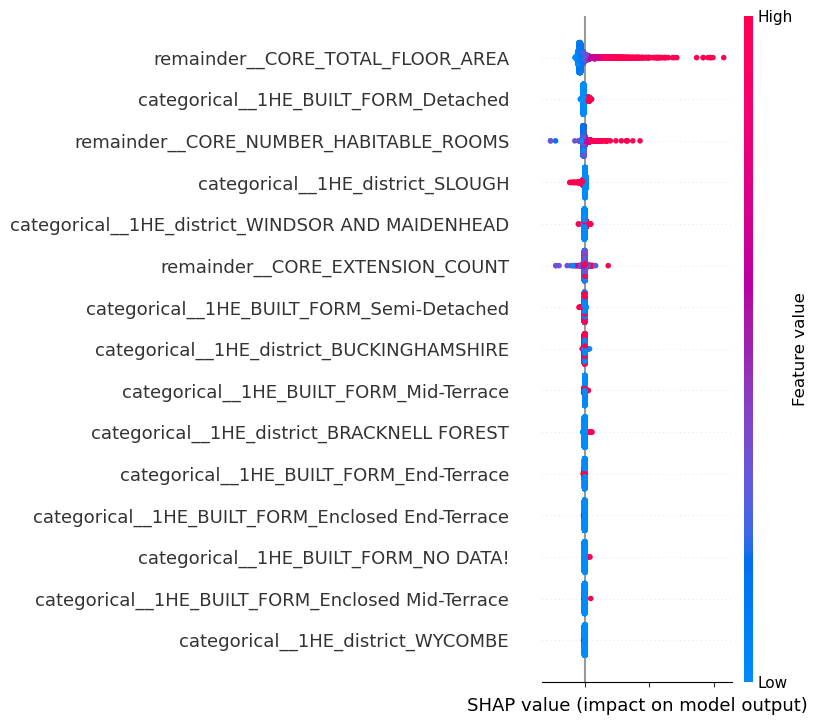

In [51]:
# SHAP Values

X_test_transformed = pipeline_XG.named_steps['preprocessor'].transform(X_test)

# Retrieving the names of the features
feature_names = pipeline_XG.named_steps['preprocessor'].get_feature_names_out()

# Explaining Model Predictions
explainer = shap.TreeExplainer(pipeline_XG.named_steps['regressor'])
shap_values = explainer(X_test_transformed)
shap_values.feature_names = list(feature_names)

# Visualising
#shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)
#plt.figure(figsize=(12,10))
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    max_display=15,
    show=False
)
#shap.plots.waterfall(shap_values[0], max_display=10)

ax = plt.gca()
ax.set_xticklabels([]) # Removes Overlapping Annotations
#ax.set_xlabel("")

plt.show()

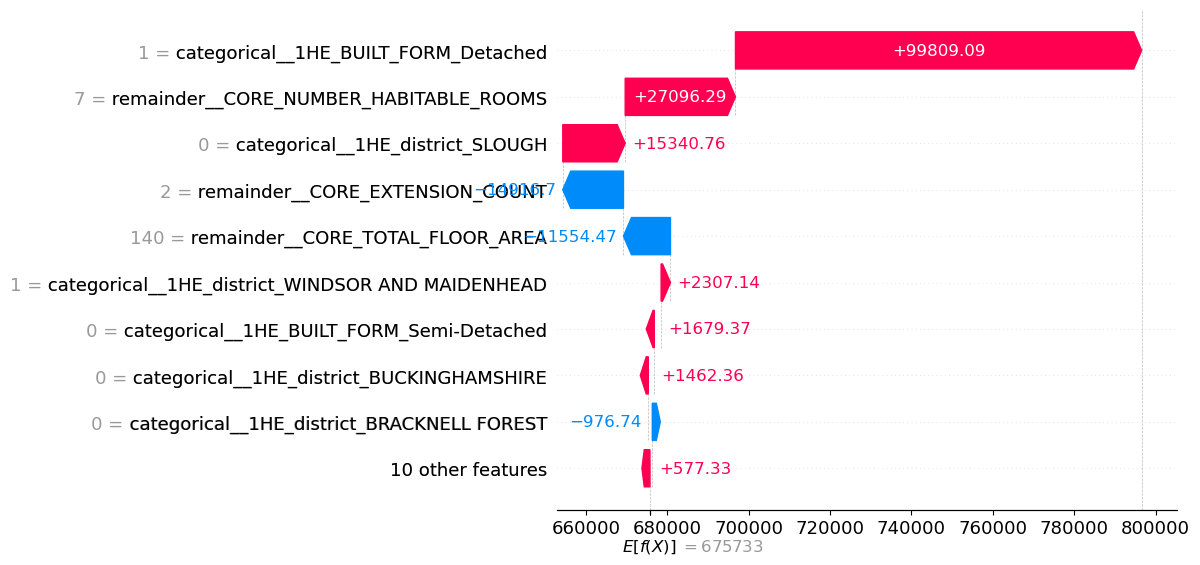

In [52]:
shap.plots.waterfall(shap_values[0], max_display=10,show=False)

ax = plt.gca()

for text in ax.texts:
    text.set_visible(False)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()